In [112]:
#Useful ibrarires and functions
import numpy as np
import matplotlib.pyplot as plt
import math
from tqdm import trange
from IPython.display import Video

from flygym.mujoco import Parameters, NeuroMechFly
from flygym.mujoco.arena import FlatTerrain
from flygym.mujoco.arena.tethered import Tethered
from flygym.mujoco.examples.common import PreprogrammedSteps
from flygym.mujoco.examples.cpg_controller import CPGNetwork

from gymnasium import spaces
from gymnasium.utils.env_checker import check_env
import cv2

In [113]:
#Implementing a standard tripod gait for the walk
#Taken from exercices sessions.
_tripod_phase_biases = np.pi * np.array(
    [
        [0, 1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 0],
        [0, 1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 0],
        [0, 1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 0],
    ]
)
_tripod_coupling_weights = (_tripod_phase_biases > 0) * 10

In [114]:
#Implementing a windy arena with a laminar wind
from dm_control.mjcf.physics import Physics


class WindArena(FlatTerrain):
    def __init__(
        self,

        #Change wind direction here
        #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        wind_vector=[ 0, 0, 0],
        #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

        medium_density=0.01,
        medium_viscosity=0.01,
        **kwargs
    ):
        super().__init__(**kwargs)
        self._add_wind(wind_vector, medium_density, medium_viscosity)
        self.wind_vector = wind_vector

    def _add_wind(self, wind_vector, medium_density, medium_viscosity):
        # Here we directly change the fields of the xml option element
        self.root_element.option.__setattr__("density", medium_density)
        self.root_element.option.__setattr__("viscosity", medium_viscosity)
        self.root_element.option.__setattr__("wind", wind_vector)
    

wind_arena = WindArena()

In [115]:
from typing import Any, Dict, Tuple

#Create a NeuromechFly Class with a fly that will be able to follow the wind in a windy area
class WindTurningNMF(NeuroMechFly):
    def __init__(
        self,
        preprogrammed_steps=None,
        intrinsic_freqs=np.ones(6) * 12,
        intrinsic_amps=np.ones(6) * 1,
        phase_biases=_tripod_phase_biases,
        coupling_weights=_tripod_coupling_weights,
        convergence_coefs=np.ones(6) * 20,
        init_phases=None,
        init_magnitudes=None,
        amplitude_range=(-0.5, 1.5),
        seed=0,
        **kwargs,
    ):
        # Initialize core NMF simulation
        super().__init__(**kwargs)

        if preprogrammed_steps is None:
            preprogrammed_steps = PreprogrammedSteps()
        self.preprogrammed_steps = preprogrammed_steps
        self.intrinsic_freqs = intrinsic_freqs
        self.intrinsic_amps = intrinsic_amps
        self.phase_biases = phase_biases
        self.coupling_weights = coupling_weights
        self.convergence_coefs = convergence_coefs
        self.amplitude_range = amplitude_range

        # Define action and observation spaces
        self.action_space = spaces.Box(*amplitude_range, shape=(2,))

        # Initialize CPG network
        self.cpg_network = CPGNetwork(
            timestep=self.sim_params.timestep,
            intrinsic_freqs=intrinsic_freqs,
            intrinsic_amps=intrinsic_amps,
            coupling_weights=coupling_weights,
            phase_biases=phase_biases,
            convergence_coefs=convergence_coefs,
            seed=seed,
        )
        self.cpg_network.reset(init_phases, init_magnitudes)
    
    #Here we can change the stiffness and damping of the aristae
    def _set_joints_stiffness_and_damping(self):
        for joint in self.model.find_all("joint"):
            if joint.name in self.actuated_joints:
                joint.stiffness = self.sim_params.joint_stiffness
                joint.damping = self.sim_params.joint_damping
            elif "LArista" in joint.name:
                joint.stiffness = 0.002
                joint.damping = 2e-4
            elif "RArista" in joint.name:
                joint.stiffness = 0.002
                joint.damping = 2e-4
            elif "Head" in joint.name:
                joint.stiffness = 1000.0
                joint.damping = 1000.0
            else:
                joint.stiffness = self.sim_params.non_actuated_joint_stiffness
                joint.damping = self.sim_params.non_actuated_joint_damping

    #Here we add sensors on the aristae       
    def _add_joint_sensors(self):
        self._arista_sensors = []
        self._debug_end_effectors = []

        for side in "LR":
            arista_sensor_joint = self.model.sensor.add(
                "jointpos", name=f"jointpos_{side}Arista", joint=f"joint_{side}Arista"
            )
            arista_sensor_torque = self.model.sensor.add(
                "jointactuatorfrc", name=f"jointactuatorfrc_{side}Arista", joint=f"joint_{side}Arista"
            )
            self._arista_sensors.append(arista_sensor_torque)
            self._arista_sensors.append(arista_sensor_joint)            

        return super()._add_joint_sensors()
    

    #Retrieve the observations of the newly added sensors
    def get_observation(self):
        obs = super().get_observation()
        arista_obs = self.physics.bind(self._arista_sensors).sensordata
        obs["arista_joint_pos"] = arista_obs.copy()
        obs["arista_joint_pos_filtered"] = arista_obs.copy()
        body_pos = self.physics.bind(self._body_sensors).sensordata
        obs["body_pos"] = body_pos.copy()        
        
        return obs
    
    #TODO
    def _define_observation_space(self):
        _observation_space = {
            "joints": spaces.Box(
                low=-np.inf, high=np.inf, shape=(3, len(self.actuated_joints))
            ),
            "fly": spaces.Box(low=-np.inf, high=np.inf, shape=(4, 3)),
            "contact_forces": spaces.Box(
                low=-np.inf, high=np.inf, shape=(len(self.contact_sensor_placements), 3)
            ),
            # x, y, z positions of the end effectors (tarsus-5 segments)
            "end_effectors": spaces.Box(low=-np.inf, high=np.inf, shape=(6, 3)),
            "fly_orientation": spaces.Box(low=-np.inf, high=np.inf, shape=(3,)),
            "arista_joint_pos": spaces.Box(low=-np.inf, high=np.inf, shape=(4,)),
            "arista_joint_pos_filtered": spaces.Box(low=-np.inf, high=np.inf, shape=(4,))
        }
        if self.sim_params.enable_vision:
            _observation_space["vision"] = spaces.Box(
                low=0,
                high=255,
                shape=(2, self._mujoco_config["vision"]["num_ommatidia_per_eye"], 2),
            )
        if self.sim_params.enable_olfaction:
            _observation_space["odor_intensity"] = spaces.Box(
                low=0,
                high=np.inf,
                shape=(self.arena.odor_dimensions, len(self._antennae_sensors)),
            )
        return spaces.Dict(_observation_space)

    def reset(self, seed=None, init_phases=None, init_magnitudes=None, **kwargs):
        obs, info = super().reset(seed=seed)
        self.cpg_network.random_state = np.random.RandomState(seed)
        self.cpg_network.intrinsic_amps = self.intrinsic_amps
        self.cpg_network.intrinsic_freqs = self.intrinsic_freqs
        self.cpg_network.reset(init_phases, init_magnitudes)
        #Reset the obs by hand
        obs["arista_joint_pos"] = np.zeros((4,))
        return obs, info

    def step(self, action):
        """Step the simulation forward one timestep.

        Parameters
        ----------
        action : np.ndarray
            Array of shape (2,) containing descending signal encoding
            turning.
        """
        # update CPG parameters
        amps = np.repeat(np.abs(action[:, np.newaxis]), 3, axis=1).flatten()
        freqs = self.intrinsic_freqs.copy()
        freqs[:3] *= 1 if action[0] > 0 else -1
        freqs[3:] *= 1 if action[1] > 0 else -1
        self.cpg_network.intrinsic_amps = amps
        self.cpg_network.intrinsic_freqs = freqs

        self.cpg_network.step()

        joints_angles = []
        adhesion_onoff = []
        for i, leg in enumerate(self.preprogrammed_steps.legs):
            # get target angles from CPGs and apply correction
            my_joints_angles = self.preprogrammed_steps.get_joint_angles(
                leg,
                self.cpg_network.curr_phases[i],
                self.cpg_network.curr_magnitudes[i],
            )
            joints_angles.append(my_joints_angles)

            # get adhesion on/off signal
            my_adhesion_onoff = self.preprogrammed_steps.get_adhesion_onoff(
                leg, self.cpg_network.curr_phases[i]
            )
            adhesion_onoff.append(my_adhesion_onoff)

        action = {
            "joints": np.array(np.concatenate(joints_angles)),
            "adhesion": np.array(adhesion_onoff).astype(int),
        }
        return super().step(action)

windturning_nmf = WindTurningNMF(Parameters())
windturning_nmf._arista_sensors

[MJCF Element: <jointactuatorfrc name="jointactuatorfrc_LArista" joint="joint_LArista"/>,
 MJCF Element: <jointpos name="jointpos_LArista" joint="joint_LArista"/>,
 MJCF Element: <jointactuatorfrc name="jointactuatorfrc_RArista" joint="joint_RArista"/>,
 MJCF Element: <jointpos name="jointpos_RArista" joint="joint_RArista"/>]

In [116]:
#Declare simulation parameters

run_time = 3

contact_sensor_placements = [
    f"{leg}{segment}"
    for leg in ["LF", "LM", "LH", "RF", "RM", "RH"]
    for segment in ["Tibia", "Tarsus1", "Tarsus2", "Tarsus3", "Tarsus4", "Tarsus5"]
]

sim_params = Parameters(
    timestep=1e-4,
    render_mode="saved",
    render_camera="Animat/camera_top",
    #render_camera="Animat/camera_front_zoomin",
    render_playspeed=0.5,
    enable_adhesion=True
)

nmf = WindTurningNMF(
    sim_params = sim_params,
    arena = wind_arena,
    contact_sensor_placements=contact_sensor_placements,
    spawn_pos=(0,0,0.2),
)

In [118]:
#Run the simulation
obs_list = []
magnitude_hist = []
end_effector_L = []
end_effector_R = []

AverageWindowL = np.array([])
AverageWindowR = np.array([])

target_num_steps = int(run_time / nmf.timestep)

obs, info = nmf.reset(seed=0)

for i in trange(target_num_steps) :
    curr_time = i * nmf.sim_params.timestep #Curr_time is always declared in the exercises but never used

    #The aristae joint posed will be averaged through a sliding window to obtain a smoother signal
    AverageWindowL=np.append(AverageWindowL,obs["arista_joint_pos"][1])
    AverageWindowR=np.append(AverageWindowR,obs["arista_joint_pos"][3])

    if(len(AverageWindowL)>=2000):
       AverageWindowL=np.delete(AverageWindowL,0)
       AverageWindowR=np.delete(AverageWindowR,0)

    obs["arista_joint_pos_filtered"][1]=np.mean(AverageWindowL)
    obs["arista_joint_pos_filtered"][3]=np.mean(AverageWindowR)

    L = obs["arista_joint_pos_filtered"][1]
    R = obs["arista_joint_pos_filtered"][3]

    #The fly walk straight or starts turning if a bias indicating wind is sensed in the antenae
    if((L-R)>0.006) :
        action=np.array([1, 1])
    elif((R-L)>0.006) :
        action=np.array([1, 1])
    else :
        action = np.array([1, 1])
    
    
    obs, reward, terminated, truncated, info = nmf.step(action)

    obs_list.append(obs)    

    end_effector_L.append(nmf.physics.named.data.qpos[f"Animat/joint_LArista"].copy())
    end_effector_R.append(nmf.physics.named.data.qpos[f"Animat/joint_RArista"].copy())
    magnitude_hist.append(nmf.cpg_network.curr_magnitudes.copy())

    nmf.render()


nmf.save_video("arista.mp4", 0)

100%|██████████| 30000/30000 [25:11<00:00, 19.84it/s]


In [119]:
#Play the video
Video("./arista.mp4")

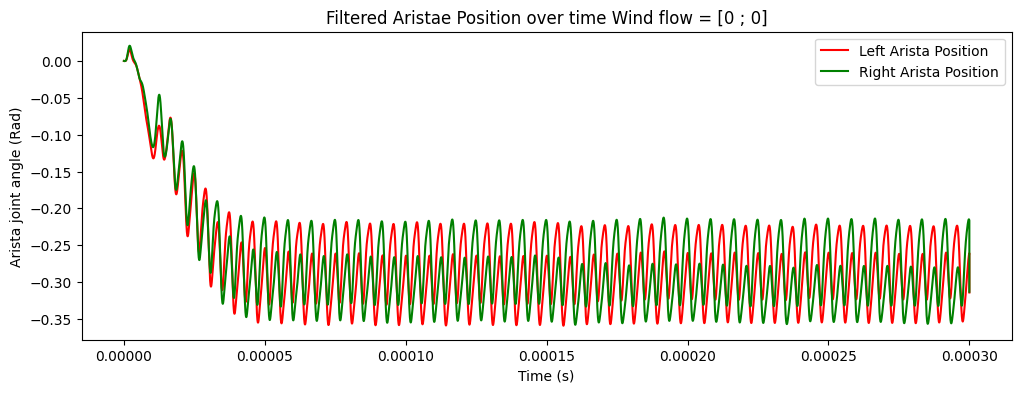

In [120]:
#Plot the aristae position over time

arista_joint_filtered = np.array([obs["arista_joint_pos_filtered"] for obs in obs_list])
time = np.linspace(0, run_time, target_num_steps) * nmf.timestep

# Create a figure and a set of subplots
fig, ax1 = plt.subplots(figsize=(12, 4))


# Create a second y-axis for the second and fourth curves
ax1.plot(time, arista_joint_filtered[:, 1], 'r', label="Left Arista Position")
ax1.plot(time, arista_joint_filtered[:, 3], 'g', label="Right Arista Position")
ax1.set_ylabel('Arista joint angle (Rad)')
ax1.set_xlabel('Time (s)')
ax1.legend(loc='best')
plt.title("Filtered Aristae Position over time Wind flow = ["+str(wind_arena.wind_vector[0])+" ; "+str(wind_arena.wind_vector[1])+"]")

plt.show()

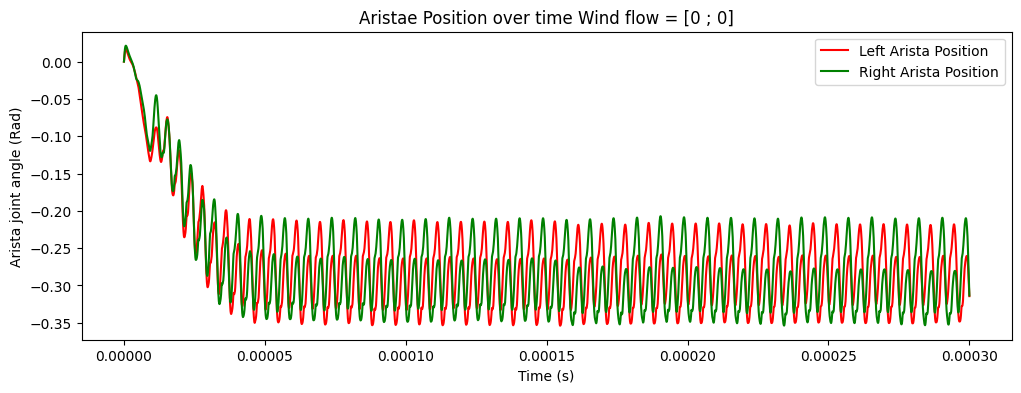

In [121]:
#Plot the aristae position over time

arista_joint = np.array([obs["arista_joint_pos"] for obs in obs_list])
time = np.linspace(0, run_time, target_num_steps) * nmf.timestep

# Create a figure and a set of subplots
fig, ax1 = plt.subplots(figsize=(12, 4))


# Create a second y-axis for the second and fourth curves
ax1.plot(time, arista_joint[:, 1], 'r', label="Left Arista Position")
ax1.plot(time, arista_joint[:, 3], 'g', label="Right Arista Position")
ax1.set_ylabel('Arista joint angle (Rad)')
ax1.set_xlabel('Time (s)')
ax1.legend(loc='best')
plt.title("Aristae Position over time Wind flow = ["+str(wind_arena.wind_vector[0])+" ; "+str(wind_arena.wind_vector[1])+"]")

plt.show()

Text(0.5, 1.0, 'Difference in arista position Wind flow = [0 ; 0]')

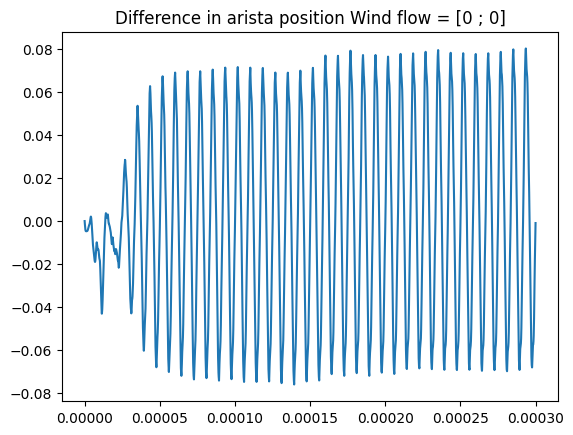

In [122]:
#Plot the difference of position across aristae.
plt.plot(time,(np.array(arista_joint[:, 1]) - np.array(arista_joint[:, 3])))
plt.title("Difference in arista position Wind flow = ["+str(wind_arena.wind_vector[0])+" ; "+str(wind_arena.wind_vector[1])+"]")

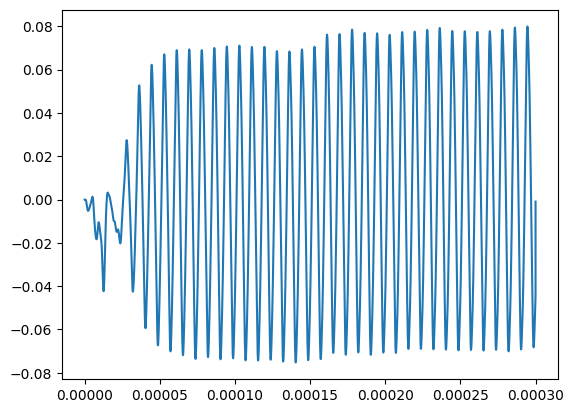

In [123]:
#Plot the filtered difference of position across aristae.
plt.plot(time,(np.array(arista_joint_filtered[:, 1]) - np.array(arista_joint_filtered[:, 3])))

In [124]:
fly_orient=np.array([obs["fly_orientation"] for obs in obs_list])
fly_orient[:,:2].shape

(30000, 2)

Text(0.5, 0, 'Time')

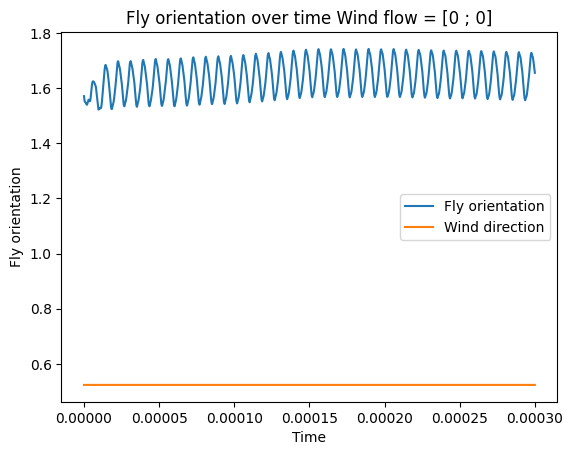

In [125]:
#Plot fly orientation with respect to wind direction

fly = np.array([obs["fly"] for obs in obs_list])
fly_orient_x = fly[:,2,0]
plt.plot(time,fly_orient_x)

# Change the target direction here with respect to the wind direction
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

wind_dir = np.pi/6

#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

plt.plot(time,np.ones(len(time))*wind_dir)
plt.legend(("Fly orientation","Wind direction"))
plt.title("Fly orientation over time Wind flow = ["+str(wind_arena.wind_vector[0])+" ; "+str(wind_arena.wind_vector[1])+"]")
plt.ylabel("Fly orientation")
plt.xlabel("Time")

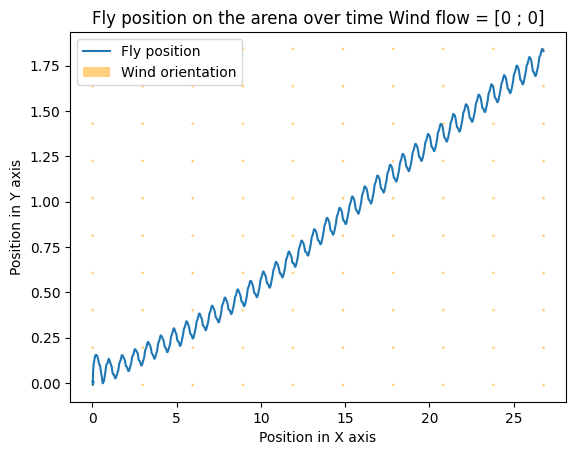

In [126]:
#Plot the position of the fly on the arena over time
body_pos = np.array([obs["body_pos"] for obs in obs_list])
plt.plot(body_pos[:,0], body_pos[:,1])
plt.title("Fly position on the arena over time Wind flow = ["+str(wind_arena.wind_vector[0])+" ; "+str(wind_arena.wind_vector[1])+"]")

x_min, x_max = np.min(body_pos[:,0]), np.max(body_pos[:,0])
y_min, y_max = np.min(body_pos[:,1]), np.max(body_pos[:,1])
x, y = np.meshgrid(np.linspace(x_min, x_max, 10), np.linspace(y_min, y_max, 10))

# Define the vector field components
u = wind_arena.wind_vector[0] * np.ones_like(x)  # X component of vector
v = wind_arena.wind_vector[1] * np.ones_like(y)   # Y component of vector

# Add quiver plot (vector field) as a sparse background
plt.quiver(x, y, u, v, color = 'orange', alpha=0.5, scale=20)


plt.xlabel("Position in X axis")
plt.ylabel("Position in Y axis")

plt.legend(("Fly position","Wind orientation"))

In [127]:
(wind_arena.wind_vector/np.linalg.norm(wind_arena.wind_vector))

C:\Users\killg\AppData\Local\Temp\ipykernel_11308\3792397986.py:1: RuntimeWarning: invalid value encountered in divide
  (wind_arena.wind_vector/np.linalg.norm(wind_arena.wind_vector))


array([nan, nan, nan])

NameError: name 'wind_norm' is not defined

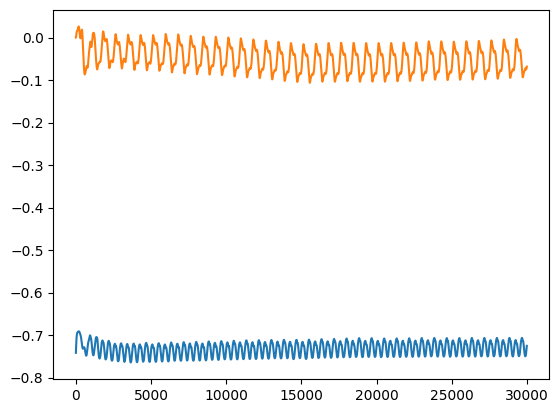

In [128]:
plt.plot(-fly_orient[:,:2])
plt.plot(wind_norm)

Text(0, 0.5, 'Dot Product')

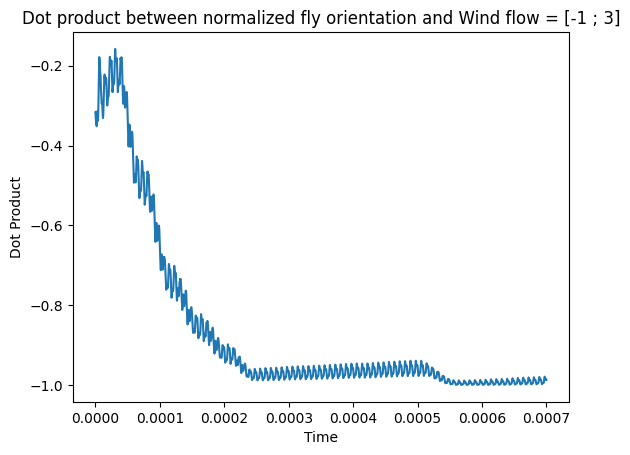

In [ ]:
#Plot the dot product of the reversed fly orientation and the wind vector
fly = np.array([obs["fly"] for obs in obs_list])
windx=np.ones(body_pos.shape[0])*wind_arena.wind_vector[0]
windy=np.ones(body_pos.shape[0])*wind_arena.wind_vector[1]

fly_norm_orient = fly_orient[:,:2] / np.linalg.norm(fly_orient[:,:2], axis=1, keepdims=True)

wind_norm = np.tile(wind_arena.wind_vector[:2], (body_pos.shape[0], 1)) / (np.linalg.norm(np.array([wind_arena.wind_vector[0], wind_arena.wind_vector[1]])))
dot_product = np.sum(fly_norm_orient * wind_norm, axis=1)

plt.plot(time, dot_product)
plt.title("Dot product between normalized fly orientation and Wind flow = ["+str(wind_arena.wind_vector[0])+" ; "+str(wind_arena.wind_vector[1])+"]")
#plt.ylim((0,None))
plt.xlabel("Time")
plt.ylabel("Dot Product")

In [ ]:
#Apply an arrow to the video showing the wind direction

cap = cv2.VideoCapture("arista.mp4")
frame_width = int(cap.get(3)) 
frame_height = int(cap.get(4)) 
fps = cap.get(cv2.CAP_PROP_FPS) 
normalised_arrow = wind_arena.wind_vector[0:2]/np.linalg.norm(wind_arena.wind_vector[0:2])
   
size = (frame_width, frame_height)
out = cv2.VideoWriter('arista_arrow.mp4', cv2.VideoWriter_fourcc(*'MJPG'), fps, size)

In [ ]:
while(True): 
      
    # reading from frame 
    ret,frame = cap.read() 
    if ret: 

        cv2.arrowedLine(
            frame,
            (int(frame_width/2), int(frame_height/2)),
            # Need to invert sign of y coordinate as the zero is on top
            (int(frame_width/2+100*wind_arena.wind_vector[0]), int(frame_height/2-100*wind_arena.wind_vector[1])),
            color=(0, 0, 255),
            thickness=2,
            tipLength=0.1,
        )

        # save all frames as a video
        out.write(frame)
    else: 
        break

# Release all space and windows once done 
cap.release() 
out.release()
cv2.destroyAllWindows()

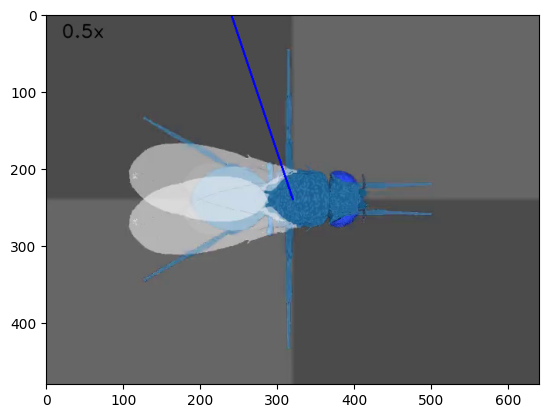

In [ ]:
cap = cv2.VideoCapture("arista.mp4")
ret,frame = cap.read() 
cv2.arrowedLine(
            frame,
            (int(frame_width/2), int(frame_height/2)),
            # Need to invert sign of y coordinate as the zero is on top
            #(int(frame_width/2)+50*wind_arena.wind_vector[0], int(frame_height/2)-50*wind_arena.wind_vector[1]),
            (int(frame_width/2+100*wind_arena.wind_vector[0]), int(frame_height/2-100*wind_arena.wind_vector[1])),
            color=(0, 0, 255),
            thickness=2,
            tipLength=0.1,
        )
plt.imshow(frame)